<a href="https://colab.research.google.com/github/xinconggg/Machine-Learning/blob/main/Customizing%20and%20Training%20with%20TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TensorFlow's Python API
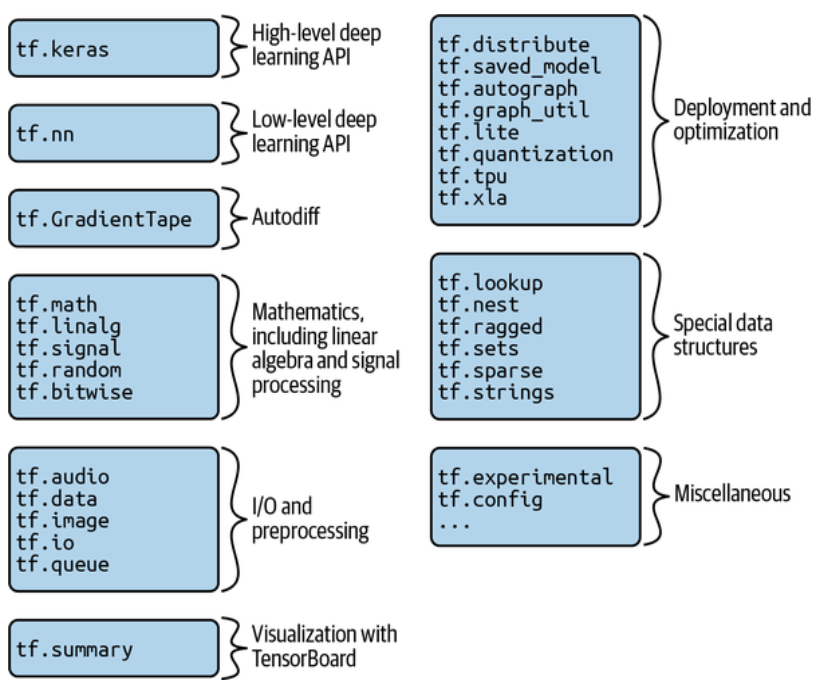

## Customizing Models and Training Algorithms
### Custom Loss Functions
Suppose we want to train a regression model, but the training set is too noisy. However, after trying to start by cleaning up the dataset by removing or fixing outliers, it is still insufficient; the dataset is still noisy. So, which loss function should be used? The *Mean Squared Error (MSE)* might penalize large errors too much and cause the model to be imprecise. The *Mean Absolute Error (MAE)* would not penalize outliers as much, but training might take some time to converge and the trained model might not be precise. So, it might be best to use *Huber Loss*, which:
- Combines the best properties of MSE and MAE.
- Less sensitive to outliers compared to MSE.
- Smooths the loss curve, making optimization more stable.<br>

Even though there exists a function for *Huber Loss* in TensorFlow:  `tf.keras.losses.Huber` class, pretend it does not exist, then it can be created using:



In [1]:
import tensorflow as tf

# Create a function that takes the labels and the model's predictions as arguments
def huber_fn(y_true, y_pred):
  error = y_true - y_pred
  is_small_error = tf.abs(error) < 1
  squared_loss = tf.square(error) / 2
  linear_loss = tf.abs(error) - 0.5
  return tf.where(is_small_error, squared_loss, linear_loss)

To test the custom loss function, create a basic Keras model and train it on the California housing dataset:

In [2]:
# Loads, splits and scales the California housing dataset, then creates a simple Keras model

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

input_shape = X_train.shape[1:]

tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


The Huber Loss function created can now be used when compiling the Keras model, then train the model as usual:

In [3]:
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.7494 - mae: 1.1371 - val_loss: 0.3474 - val_mae: 0.6522
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2607 - mae: 0.5681 - val_loss: 0.2553 - val_mae: 0.5383


### Custom Training Loops
In some cases, the `fit` method may not be flexible enough. For example, the *Wide & Deep Learning* uses 2 different optimizers: 1 for wide path and 1 for deep path. Since the `fit` method only uses 1 optimizer, implementing *Wide & Deep Learning* will require us to create a custom training loop.

First, build a simple model:

In [4]:
tf.keras.utils.set_random_seed(42)

l2_reg = tf.keras.regularizers.l2(0.05)
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          kernel_regularizer=l2_reg),
    tf.keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

Next, create a function that will randomly sample a bath of instances from the training set:

In [5]:
import numpy as np

def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

Create another function that displays the training status, including the number of steps, the total number of steps, the mean loss since the start of epoch, and other metrics:

In [6]:
def print_status_bar(step, total, loss, metrics=None):
    metrics = " - ".join([f"{m.name}: {m.result():.4f}" #.4f formats the result as a float with 4 digits after the decimal point
                          for m in [loss] + (metrics or [])])
    end = "" if step < total else "\n"
    print(f"\r{step}/{total} - " + metrics, end=end)

Define some hyperparameters and choose the optimizer, loss function and the metrics (just MAE in this example):

In [7]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.MeanSquaredError()
mean_loss = tf.keras.metrics.Mean()
metrics = [tf.keras.metrics.MeanAbsoluteError()]

Now, we are ready to build the custom training loop:

In [8]:
for epoch in range(1, n_epochs + 1):
    print(f"Epoch {epoch}/{n_epochs}")
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch, training=True)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # extra code – if your model has variable constraints
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))

        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)

        print_status_bar(step, n_steps, mean_loss, metrics)

    for metric in [mean_loss] + metrics:
        metric.reset_state()

Epoch 1/5
362/362 - mean: 3.5419 - mean_absolute_error: 0.6640
Epoch 2/5
362/362 - mean: 1.8693 - mean_absolute_error: 0.5431
Epoch 3/5
362/362 - mean: 1.1428 - mean_absolute_error: 0.5030
Epoch 4/5
362/362 - mean: 0.8501 - mean_absolute_error: 0.4977
Epoch 5/5
362/362 - mean: 0.7280 - mean_absolute_error: 0.5014


#### Explanation of the Custom Training Loop
- 2 nested loop was created, 1 for the epochs, another for the batches within an epoch
- Then we sample a random batch from the training set
- Inside the `tf.GradientTape()` block, we make a prediction for one
batch, using the model as a function, and we compute the loss: it is
equal to the main loss plus the other losses (in this model, there is one
regularization loss per layer). Since the `mean_squared_error()`
function returns one loss per instance, we compute the mean over the
batch using `tf.reduce_mean()` (if you wanted to apply different
weights to each instance, this is where you would do it). The
regularization losses are already reduced to a single scalar each, so we
just need to sum them (using `tf.add_n()`, which sums multiple
tensors of the same shape and data type)
- Next, the tape compute the gradients of the loss with regard to each trainable variable and we apply them to theoptimizer to perform a gradient descent step
- Then we update the mean loss and metrics and display the status bar
- At the end of each epoch, we reset the states of the mean loss and the metrics